In [2]:
import datetime
from src import CompanyDetails, FindValues, Analyse,PredictValues, SharePricePrediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam

In [15]:
c_list = ['RELIANCE','HDFCBANK','ICICIBANK', 'INFY']
c_name = c_list[3]
company_details = CompanyDetails(c_name)
share_price_df = company_details.sharePriceRange(period='25y')
share_price_df['Date'] = share_price_df['Date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d')).sort_index()
share_price_df.index = share_price_df.pop('Date')

print(share_price_df)

              Close       ema100       ema200
Date                                         
2000-03-28    99.64    99.640000    99.640000
2000-03-29   102.06    99.687921    99.664080
2000-03-30    97.62    99.646972    99.643741
2000-03-31    89.85    99.452972    99.546290
2000-04-03    82.66    99.120438    99.378268
...             ...          ...          ...
2025-03-24  1592.75  1797.187883  1768.690247
2025-03-25  1628.45  1793.846539  1767.294822
2025-03-26  1599.45  1789.997102  1765.624724
2025-03-27  1603.55  1786.305080  1764.012040
2025-03-28  1570.65  1782.034683  1762.088040

[6240 rows x 3 columns]


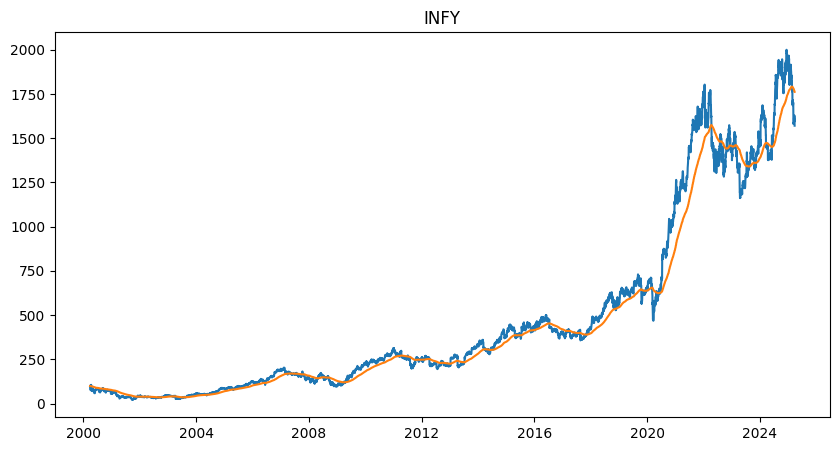

In [16]:
plt.figure(figsize=(10, 5))
plt.title(c_name)
plt.plot(share_price_df.index, share_price_df['Close'])
plt.plot(share_price_df.index, share_price_df['ema200'])

In [17]:
def create_windows_for_company(df, window_size=5):
    """
    Given a DataFrame with columns ['Close', 'EMA200'],
    create input windows (X) and corresponding target values (y).
    
    X shape => (num_samples, window_size, 2)  # 2 features: Close & EMA200
    y shape => (num_samples,)                # Predict next day's Close
    """
    X, y = [], []
    
    # Sort by date if not already
    df = df.sort_index()  # assumes date is the index
    close_vals = df['Close'].values
    ema_vals   = df['ema200'].values
    
    for i in range(len(df) - window_size):
        # Window from i to i+window_size-1
        X_window = []
        for j in range(window_size):
            X_window.append([close_vals[i+j], ema_vals[i+j]])
        
        # Target is the Close at i+window_size
        target = close_vals[i + window_size]
        
        X.append(X_window)
        y.append(target)
    
    return np.array(X), np.array(y)

In [18]:
def load_and_combine_data(list_of_dataframes, window_size=5):
    """
    Accepts multiple DataFrames (one per company).
    Returns combined X, y for training the model on all companies' data.
    """
    X_combined, y_combined = [], []
    
    for df in list_of_dataframes:
        X, y = create_windows_for_company(df, window_size)
        if len(X) > 0:
            X_combined.append(X)
            y_combined.append(y)
    
    # Concatenate all arrays
    if len(X_combined) == 0:
        raise ValueError("No data found after window creation.")
    
    X_all = np.concatenate(X_combined, axis=0)
    y_all = np.concatenate(y_combined, axis=0)
    return X_all, y_all


In [19]:
def train_model(X, y, window_size=5):
    """
    Build, compile, and train an LSTM model on the combined dataset.
    Returns the trained model.
    """
    # Split into train (80%), val (10%), test (10%) - or any ratio you prefer
    num_samples = len(X)
    train_end = int(num_samples * 0.8)
    val_end   = int(num_samples * 0.9)
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
    X_test,  y_test  = X[val_end:], y[val_end:]
    
    # Build LSTM model
    model = Sequential([
        Input(shape=(window_size, 2)),  # 2 features: Close, EMA200
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # predict next day's Close
    ])
    
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.001),
        metrics=['mae']
    )
    
    # Train
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32
    )
    
    # Evaluate on test set (optional, just to see performance)
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    
    return model


In [20]:
c_list = ['RELIANCE','HDFCBANK','ICICIBANK', 'INFY']
list_of_df = []
windowsize = 5
for c in c_list:
    company_details = CompanyDetails(c)
    share_price_df = company_details.sharePriceRange(period='25y')
    share_price_df['Date'] = share_price_df['Date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d')).sort_index()
    share_price_df.index = share_price_df.pop('Date')

    list_of_df.append(share_price_df)

print(list_of_df)

[              Close       ema100       ema200
Date                                         
2000-03-28    12.28    12.280000    12.280000
2000-03-29    11.87    12.271881    12.275920
2000-03-30    12.82    12.282735    12.281334
2000-03-31    13.85    12.313770    12.296943
2000-04-03    14.38    12.354685    12.317670
...             ...          ...          ...
2025-03-24  1302.10  1272.271370  1310.788938
2025-03-25  1285.45  1272.532333  1310.536809
2025-03-26  1273.05  1272.542584  1310.163806
2025-03-27  1278.20  1272.654612  1309.845758
2025-03-28  1275.10  1272.703035  1309.500029

[6237 rows x 3 columns],               Close       ema100       ema200
Date                                         
2000-03-28    22.56    22.560000    22.560000
2000-03-29    21.76    22.544158    22.552040
2000-03-30    21.53    22.524076    22.541870
2000-03-31    21.09    22.495679    22.527424
2000-04-03    20.27    22.451606    22.504962
...             ...          ...          ...
2025-03

In [21]:
print(list_of_df)

[              Close       ema100       ema200
Date                                         
2000-03-28    12.28    12.280000    12.280000
2000-03-29    11.87    12.271881    12.275920
2000-03-30    12.82    12.282735    12.281334
2000-03-31    13.85    12.313770    12.296943
2000-04-03    14.38    12.354685    12.317670
...             ...          ...          ...
2025-03-24  1302.10  1272.271370  1310.788938
2025-03-25  1285.45  1272.532333  1310.536809
2025-03-26  1273.05  1272.542584  1310.163806
2025-03-27  1278.20  1272.654612  1309.845758
2025-03-28  1275.10  1272.703035  1309.500029

[6237 rows x 3 columns],               Close       ema100       ema200
Date                                         
2000-03-28    22.56    22.560000    22.560000
2000-03-29    21.76    22.544158    22.552040
2000-03-30    21.53    22.524076    22.541870
2000-03-31    21.09    22.495679    22.527424
2000-04-03    20.27    22.451606    22.504962
...             ...          ...          ...
2025-03

In [22]:
x_all, y_all = load_and_combine_data(list_of_df, windowsize)
print(x_all)

[[[  12.28         12.28      ]
  [  11.87         12.2759204 ]
  [  12.82         12.28133413]
  [  13.85         12.29694274]
  [  14.38         12.31766968]]

 [[  11.87         12.2759204 ]
  [  12.82         12.28133413]
  [  13.85         12.29694274]
  [  14.38         12.31766968]
  [  13.23         12.32674759]]

 [[  12.82         12.28133413]
  [  13.85         12.29694274]
  [  14.38         12.31766968]
  [  13.23         12.32674759]
  [  13.23         12.33573518]]

 ...

 [[1586.55       1773.82135535]
  [1615.55       1772.24651599]
  [1592.55       1770.45849096]
  [1592.75       1768.69024727]
  [1628.45       1767.29482192]]

 [[1615.55       1772.24651599]
  [1592.55       1770.45849096]
  [1592.75       1768.69024727]
  [1628.45       1767.29482192]
  [1599.45       1765.62472419]]

 [[1592.55       1770.45849096]
  [1592.75       1768.69024727]
  [1628.45       1767.29482192]
  [1599.45       1765.62472419]
  [1603.55       1764.01204037]]]


In [23]:
model = train_model(x_all, y_all, windowsize)
model.save("relinace_hdfc_icici_infy.h5")

Epoch 1/100
609/609 [==============================] - 6s 5ms/step - loss: 89966.8672 - mae: 116.3168 - val_loss: 47.2546 - val_mae: 5.2625
Epoch 2/100
609/609 [==============================] - 3s 5ms/step - loss: 892.5758 - mae: 13.8623 - val_loss: 95.1083 - val_mae: 7.8159
Epoch 3/100
609/609 [==============================] - 3s 4ms/step - loss: 1209.4961 - mae: 16.0256 - val_loss: 68.2544 - val_mae: 6.6191
Epoch 4/100
609/609 [==============================] - 2s 4ms/step - loss: 1029.8042 - mae: 14.6172 - val_loss: 747.0321 - val_mae: 20.5736
Epoch 5/100
609/609 [==============================] - 2s 4ms/step - loss: 1316.9294 - mae: 17.8547 - val_loss: 44.7840 - val_mae: 5.0496
Epoch 6/100
609/609 [==============================] - 3s 4ms/step - loss: 1167.7340 - mae: 16.9916 - val_loss: 332.0169 - val_mae: 16.7669
Epoch 7/100
609/609 [==============================] - 3s 4ms/step - loss: 894.0333 - mae: 15.3968 - val_loss: 376.8830 - val_mae: 15.8948
Epoch 8/100
609/609 [=======

In [19]:
print(model.input_shape)

(None, 5, 2)


In [ ]:
user_c_name = 'TATAMOTORS'
# model = load_model("5_companies_train_model.h5")
cdsl_details = CompanyDetails(user_c_name)
cdsl_share_price_df = cdsl_details.sharePriceRange('10y')
cdsl_share_price_df['Date'] = cdsl_share_price_df['Date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d')).sort_index()
cdsl_share_price_df.index = cdsl_share_price_df.pop('Date')
print(cdsl_share_price_df)

             Close      ema100      ema200
Date                                      
2015-03-27  526.19  526.190000  526.190000
2015-03-30  530.76  526.280495  526.235473
2015-03-31  540.78  526.567614  526.380194
2015-04-01  555.23  527.135186  526.667257
2015-04-06  564.41  527.873301  527.042807
...            ...         ...         ...
2025-03-21  702.95  747.610007  801.913669
2025-03-24  713.50  746.934561  801.033931
2025-03-25  710.30  746.209125  800.131106
2025-03-26  708.25  745.457459  799.216866
2025-03-27  668.55  743.934539  797.916698

[2470 rows x 3 columns]


In [15]:
def create_windows_for_inference(df, window_size=5):
    """
    Similar to create_windows_for_company but 
    doesn't produce 'y' if you want purely forward predictions.
    
    If you do want to evaluate, you can keep the target creation as well.
    """
    X = []
    df = df.sort_index()
    
    close_vals = df['Close'].values
    ema_vals   = df['ema200'].values
    
    for i in range(len(df) - window_size):
        window = []
        for j in range(window_size):
            window.append([close_vals[i+j], ema_vals[i+j]])
        X.append(window)
    
    return np.array(X)

In [16]:
x_infer = create_windows_for_inference(cdsl_share_price_df, window_size=5)
print(x_infer.shape)

(2465, 5, 2)


In [17]:
predictions = model.predict(x_infer)
pred_dates = cdsl_share_price_df.index[windowsize:]

result_df = pd.DataFrame()
result_df['Date'] = pred_dates
result_df['Close'] = predictions.flatten()
result_df.set_index('Date', inplace=True)

print(result_df)

78/78 [==============================] - 1s 2ms/step
                 Close
Date                  
2015-04-07  561.713135
2015-04-08  560.231689
2015-04-09  560.823608
2015-04-10  560.895752
2015-04-13  561.735596
...                ...
2025-03-21  580.298035
2025-03-24  611.386414
2025-03-25  652.666992
2025-03-26  634.148865
2025-03-27  625.830444

[2465 rows x 1 columns]


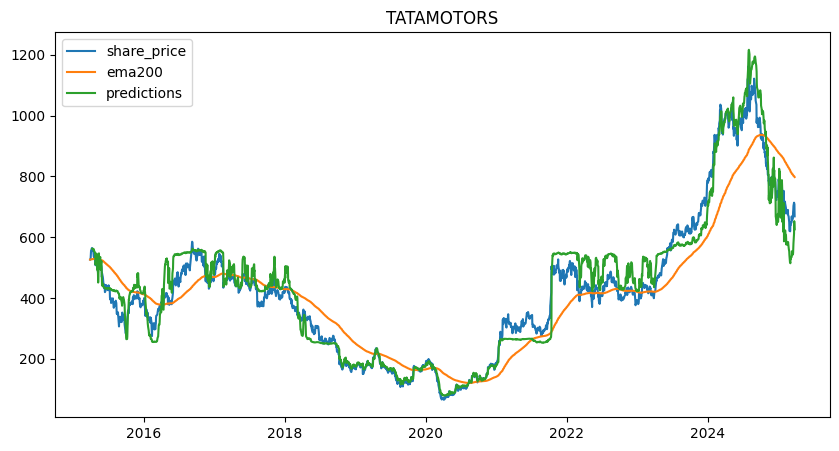

In [18]:
plt.figure(figsize=(10, 5))
plt.title(user_c_name)
plt.plot(cdsl_share_price_df.index, cdsl_share_price_df['Close'])
plt.plot(cdsl_share_price_df.index, cdsl_share_price_df['ema200'])
plt.plot(result_df.index, result_df['Close'])
plt.legend(['share_price', 'ema200', 'predictions'])

In [ ]:
future_year = 5
offset_ratio = 0.05
last_row = cdsl_share_price_df.iloc[-1]
last_know_date = cdsl_share_price_df.index[-1]
last_close = last_row['Close']
last_ema = last_row['ema200']

last_window = cdsl_share_price_df['Close'].tail(windowsize).to_numpy().reshape(windowsize, 1)
print(last_close)

In [ ]:
future_months = []
current_month = (last_know_date.year, last_know_date.month)

for _ in range(future_year * 12):
    year, month = current_month
    month += 1
    if month > 12:
        month = 1
        year += 1
    current_month = (year, month)
    future_months.append(datetime.datetime(year=year, month=month, day=1))

print(future_months)
print(model)

In [ ]:
future_ema200 = []
current_window = last_window.copy()

for _ in range(future_year * 12):
    # Reshape for the model (1, window_size, 1)
    input_data = np.expand_dims(current_window, axis=0)
    # Predict the next month's EMA value
    pred_ema = model.predict(input_data)
    pred_ema_val = pred_ema.flatten()[0]
    
    # Store predicted EMA200
    future_ema200.append(pred_ema_val)
    
    # Slide the window by removing oldest value, adding new predicted value
    current_window = np.vstack([current_window[1:], [[pred_ema_val]]])

print(future_ema200)

In [ ]:
import numpy as np
import pandas as pd
import datetime

# Define window size (number of days in the input sequence)
window_size = 5

# Build the initial window using both 'Close' and 'ema200'
# This ensures the shape is (window_size, 2)
cdsl_last_window = cdsl_share_price_df[['Close', 'ema200']].tail(window_size).to_numpy()
print("Initial window shape:", cdsl_last_window.shape)  # Expected: (5, 2)
print("Last window rows:\n", cdsl_last_window)

# Set prediction parameters
cdsl_future_year = 5  # Number of future years to forecast

# Create future monthly dates (one per month)
cdsl_future_months = []
cdsl_current_date = cdsl_share_price_df.index[-1]  # Last known date

for _ in range(cdsl_future_year * 12):
    year, month = cdsl_current_date.year, cdsl_current_date.month
    month += 1
    if month > 12:
        month = 1
        year += 1
    cdsl_current_date = datetime.datetime(year, month, 1)
    cdsl_future_months.append(cdsl_current_date)

print("Future monthly dates:")
print(cdsl_future_months)

# Set smoothing factor for EMA200 (alpha = 2/(N+1) where N=200)
alpha = 2 / 201.0

# Lists to store predictions
cdsl_future_close = []  # Predicted Close values
cdsl_future_ema = []    # Predicted EMA200 values

# Copy the last window for iterative forecasting; its shape is (5, 2)
cdsl_current_window = cdsl_last_window.copy()

# Iterative monthly forecasting loop
for _ in range(cdsl_future_year * 12):
    # Prepare input: reshape to (1, window_size, 2) to match the model's input shape
    input_data = np.expand_dims(cdsl_current_window, axis=0)
    
    # Predict next day's Close price using the model
    pred_close = model.predict(input_data)
    pred_close_val = pred_close.flatten()[0]
    
    # Compute the new EMA200 using the last EMA in the current window:
    # new_ema = (pred_close - last_ema) * alpha + last_ema
    last_ema = cdsl_current_window[-1, 1]
    new_ema = (pred_close_val - last_ema) * alpha + last_ema
    
    # Save predictions
    cdsl_future_close.append(pred_close_val)
    cdsl_future_ema.append(new_ema)
    
    # Update the window by removing the oldest row and appending the new row with both features
    new_row = np.array([[pred_close_val, new_ema]])
    cdsl_current_window = np.vstack([cdsl_current_window[1:], new_row])

print("Future Close predictions:")
print(cdsl_future_close)
print("Future EMA200 predictions:")
print(cdsl_future_ema)
